Google Drive에 Mount

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


작업 위치로 이동

In [2]:
%cd /content/drive/MyDrive/kurly_hurry_holy_moly/demand_forecasting

/content/drive/MyDrive/kurly_hurry_holy_moly/demand_forecasting


필요한 라이브러리 Import

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
from tqdm.auto import tqdm
import os
from matplotlib import pyplot as plt

각 데이터 파일 정제하여 RDS 축적 (우선 로컬로 진행)

In [4]:
data_list = os.listdir('datasets')
df = pd.DataFrame()

# 모든 데이터 파일 정제 및 합치기
for data in tqdm(data_list):
    path = 'datasets/' + data
    temp = pd.read_csv(path)
    temp = temp[temp['Order ID'].apply(lambda x: len(str(x)) == 6)]
    df = pd.concat([df, temp], ignore_index=True)

# 날짜 str -> Datetime 변환
df['Datetime'] = df['Order Date'].apply(lambda x: datetime.strptime(x, '%m/%d/%y %H:%M'))

# 정렬을 위하여 str 형태로 일자 데이터 추가
df['Date'] = df['Datetime'].apply(lambda x: datetime.strftime(x, '%Y-%m-%d'))

# 추가 데이터로 요일 정보 추가
df['Day Of Week'] = df['Datetime'].apply(lambda x: x.weekday())

# Correlation 계산을 위하여 timestamp 추가
df['Timestamp'] = df['Datetime'].apply(lambda x: time.mktime(x.timetuple()))

# 날짜 별로 정렬
df = df.sort_values('Datetime').reset_index(drop=True)

# 데이터 포맷 변환
df['Quantity Ordered'] = df['Quantity Ordered'].apply(lambda x: int(x))
df['Price Each'] = df['Price Each'].apply(lambda x: float(x))

# 컬리 전용 제품 리스트로 변경
products = pd.read_csv('products.csv')
for i in range(len(products)):
    df.loc[df['Product'] == products.loc[i, 'ori_pro'], 'Product'] = products.loc[i, 'kurly_pro']

print(len(df))
df.head()

  0%|          | 0/12 [00:00<?, ?it/s]

185950


,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Datetime,Date,Day Of Week,Timestamp
0,147268,[오늘식빵] 우유 듬뿍 식빵,1,11.99,01/01/19 03:07,"9 Lake St, New York City, NY 10001",2019-01-01 03:07:00,2019-01-01,1,1.546312e+09
1,148041,[픽어베이글] 베이글 7종,1,11.95,01/01/19 03:40,"760 Church St, San Francisco, CA 94016",2019-01-01 03:40:00,2019-01-01,1,1.546314e+09
2,149343,[농심] 신라면 멀티 5입,1,150.00,01/01/19 04:56,"735 5th St, New York City, NY 10001",2019-01-01 04:56:00,2019-01-01,1,1.546319e+09
3,149964,[KF365] DOLE 실속 바나나 1kg (필리핀),1,2.99,01/01/19 05:53,"75 Jackson St, Dallas, TX 75001",2019-01-01 05:53:00,2019-01-01,1,1.546322e+09
4,149350,[픽어베이글] 베이글 7종,2,11.95,01/01/19 06:03,"943 2nd St, Atlanta, GA 30301",2019-01-01 06:03:00,2019-01-01,1,1.546323e+09


분석에 용이한 형태로 데이터 변환

In [5]:
date_list = list(set(list(df['Date'])))
df_date = pd.DataFrame()
for dt in tqdm(date_list):
    temp = df[df['Date'] == dt].reset_index(drop=True)
    item_list = list(set(list(temp['Product'])))
    for item in item_list:
        temp2 = temp[temp['Product'] == item].reset_index(drop=True)
        total = sum(list(temp2['Quantity Ordered']))
        dow = temp2.loc[0, 'Day Of Week']
        price = temp2.loc[0, 'Price Each']
        df_date.loc[df_date.shape[0], 'Date'] = dt
        df_date.loc[df_date.shape[0]-1, 'Product'] = item
        df_date.loc[df_date.shape[0]-1, 'Quantity'] = total
        df_date.loc[df_date.shape[0]-1, 'Price Each'] = price
        df_date.loc[df_date.shape[0]-1, 'Day Of Week'] = dow
df_date.head()

  0%|          | 0/366 [00:00<?, ?it/s]

,Date,Product,Quantity,Price Each,Day Of Week
0,2019-12-26,[오늘식빵] 우유 듬뿍 식빵,100.0,11.99,3.0
1,2019-12-26,[농심] 신라면 멀티 5입,75.0,150.00,3.0
2,2019-12-26,[생활공작소] 제습제 515mL (12개입 1box),7.0,400.00,3.0
3,2019-12-26,[교토마블] 데니쉬 식빵 3종,19.0,300.00,3.0
4,2019-12-26,[그로서리서울] 배부른 현미 곤약밥 2종,37.0,149.99,3.0


EDA 작업을 위하여 그룹화 진행 및 그래프 생성

In [6]:
group_df = df_date.groupby(['Day Of Week', 'Product']).mean().reset_index()
group_df

,Day Of Week,Product,Quantity,Price Each
0,0.0,MY FIRST 처음 만나는 모닝롤,17.307692,389.99
1,0.0,[KF365] DOLE 실속 바나나 1kg (필리핀),87.384615,2.99
2,0.0,[KF365] 무라벨 플레인 탄산수 350mL 2종,13.096154,1700.00
3,0.0,[Kurly’s] R15 통밀 식빵,62.115385,14.95
4,0.0,[교토마블] 데니쉬 식빵 3종,13.615385,300.00
...,...,...,...,...
128,6.0,[오늘식빵] 우유 듬뿍 식빵,56.730769,11.99
129,6.0,[픽어베이글] 베이글 7종,65.538462,11.95
130,6.0,[하이트진로] 석수 (2L X 6개),74.423077,3.84
131,6.0,[햇반] 백미밥 210g X 6입,11.307692,109.99


비교를 위하여 월요일과 토요일의 추이 비교

In [39]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 25 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 <a list of 19 Text major ticklabel objects>)

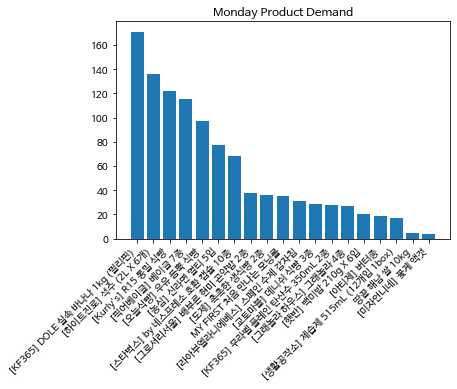

In [7]:
# 월요일

plt.rc('font', family='NanumBarunGothic')

monday = df_date[df_date['Day Of Week'] == 0].sort_values('Quantity', ascending=False).reset_index(drop=True)
plt.bar(list(monday['Product']), list(monday['Quantity']))
plt.title('Monday Product Demand')
plt.xticks(rotation=45, ha='right')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 <a list of 19 Text major ticklabel objects>)

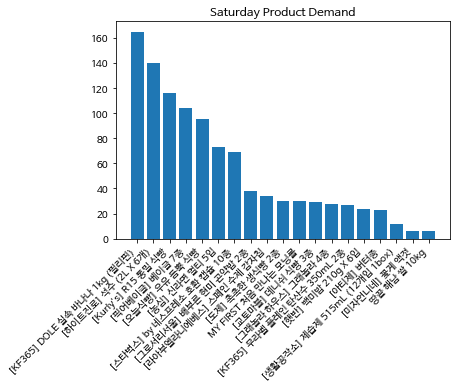

In [8]:
# 토요일

saturday = df_date[df_date['Day Of Week'] == 5].sort_values('Quantity', ascending=False).reset_index(drop=True)
plt.bar(list(saturday['Product']), list(saturday['Quantity']))
plt.title('Saturday Product Demand')
plt.xticks(rotation=45, ha='right')

머신러닝 모델 적용을 위한 데이터 변환

In [9]:
# 필요한 모듈 설치
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 79 kB/s 


In [10]:
# 필요한 모듈 Import
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.neural_network import MLPRegressor
import xgboost
import catboost

In [24]:
# 불필요한 컬럼 제거 및 제품명의 Label Encoding 진행
df_date = df_date.drop(columns=['Date'])
for i in range(len(products)):
    df_date.loc[df_date['Product'] == products.loc[i, 'kurly_pro'], 'Product'] = products.loc[i, 'label']
df_date['Product'] = df_date['Product'].apply(lambda x: int(x))
df_date

,Product,Quantity,Price Each,Day Of Week
0,5,100.0,11.99,3.0
1,6,75.0,150.00,3.0
2,17,7.0,400.00,3.0
3,12,19.0,300.00,3.0
4,8,37.0,149.99,3.0
...,...,...,...,...
6822,13,7.0,1700.00,2.0
6823,12,7.0,300.00,2.0
6824,17,5.0,400.00,2.0
6825,15,11.0,109.99,2.0


In [25]:
train = df_date.copy()
target = train.pop('Quantity')
x_train, x_test, y_train, y_test = train_test_split(train, target, test_size = 0.2)

In [26]:
train.corr()

,Product,Price Each,Day Of Week
Product,1.00000,0.593140,0.000150
Price Each,0.59314,1.000000,0.000083
Day Of Week,0.00015,0.000083,1.000000


In [27]:
# Gradient Boosting을 활용한 XGBRegressor
model = xgboost.XGBRegressor()
model.fit(x_train, y_train)
y = model.predict(x_test)
print(mean_absolute_error(y, y_test))
print(math.sqrt(mean_squared_error(y, y_test)))
print(r2_score(y, y_test))

[12:03:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
7.812605479800335
12.40239252763142
0.7579224017862054


In [22]:
x_train.dtypes

Product         object
Price Each     float64
Day Of Week    float64
dtype: object

In [28]:
# Gradient Boosting을 활용한 CatBoostRegressor

model2 = catboost.CatBoostRegressor()
model2.fit(x_train, y_train)
y = model2.predict(x_test)
print(mean_absolute_error(y, y_test))
print(math.sqrt(mean_squared_error(y, y_test)))
print(r2_score(y, y_test))

Learning rate set to 0.053539
0:	learn: 27.4298996	total: 47.5ms	remaining: 47.5s
1:	learn: 26.3068661	total: 48.7ms	remaining: 24.3s
2:	learn: 25.2740932	total: 49.8ms	remaining: 16.5s
3:	learn: 24.3248817	total: 50.8ms	remaining: 12.7s
4:	learn: 23.4448921	total: 52.2ms	remaining: 10.4s
5:	learn: 22.5990906	total: 53.2ms	remaining: 8.81s
6:	learn: 21.8011120	total: 54.3ms	remaining: 7.7s
7:	learn: 21.0730845	total: 55.1ms	remaining: 6.84s
8:	learn: 20.3624785	total: 56.2ms	remaining: 6.19s
9:	learn: 19.7050182	total: 57.1ms	remaining: 5.66s
10:	learn: 19.1397821	total: 57.9ms	remaining: 5.2s
11:	learn: 18.5838275	total: 58.8ms	remaining: 4.84s
12:	learn: 18.0798366	total: 59.6ms	remaining: 4.53s
13:	learn: 17.6123489	total: 60.6ms	remaining: 4.27s
14:	learn: 17.1546515	total: 61.6ms	remaining: 4.05s
15:	learn: 16.7376959	total: 62.6ms	remaining: 3.85s
16:	learn: 16.3854717	total: 63.4ms	remaining: 3.67s
17:	learn: 16.0470772	total: 64.3ms	remaining: 3.51s
18:	learn: 15.7376180	total:

In [29]:
# Neural Network Regressor

model3 = MLPRegressor()
model3.fit(x_train, y_train)
y = model3.predict(x_test)
print(mean_absolute_error(y, y_test))
print(math.sqrt(mean_squared_error(y, y_test)))
print(r2_score(y, y_test))

8.71590564722244
13.00131366137408
0.7024298730656511


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [30]:
# 가장 우수한 XGBRegressor 모델 저장
import pickle

with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)